# Ordinal regression
**Author:** [Benjamin Vincent](https://github.com/drbenvincent)

In [38]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr
import patsy
from scipy.stats import norm
from numpy.random import default_rng

In [39]:
%config InlineBackend.figure_format = 'retina'
rng = default_rng(12345)
az.style.use("arviz-darkgrid")

Ordinal regression is appropriate when your outcome variables are ordinal. And ordinal data are discrete, like categorical variables, but with an inherent order. Questions that might give rise to ordinal data are:
- On a scale of 1 (completely diagree) to 7 (completely agree), rate how much you agree with the statement 'I like Bayesian inference.'
- Indicate your highest education level from the choices: "1. High school", "2. Bachelors", "3. Masters", "4. PhD".

Ordinal data therefore come in the form of ordered labels which can be represented as integers. Each data point represents a choice $1, \dots, K$ where there are $K$ choices to select from.

## The cumulative ordinal data generating model
This notebook will focus exclusively upon the widely applicable _cumulative ordinal model_. There are however a number of different subclasses of ordinal models, and these are very clearly explained by Bürkner & Vuorre (2019). It is useful to demonstrate this model with an explanatory diagram.

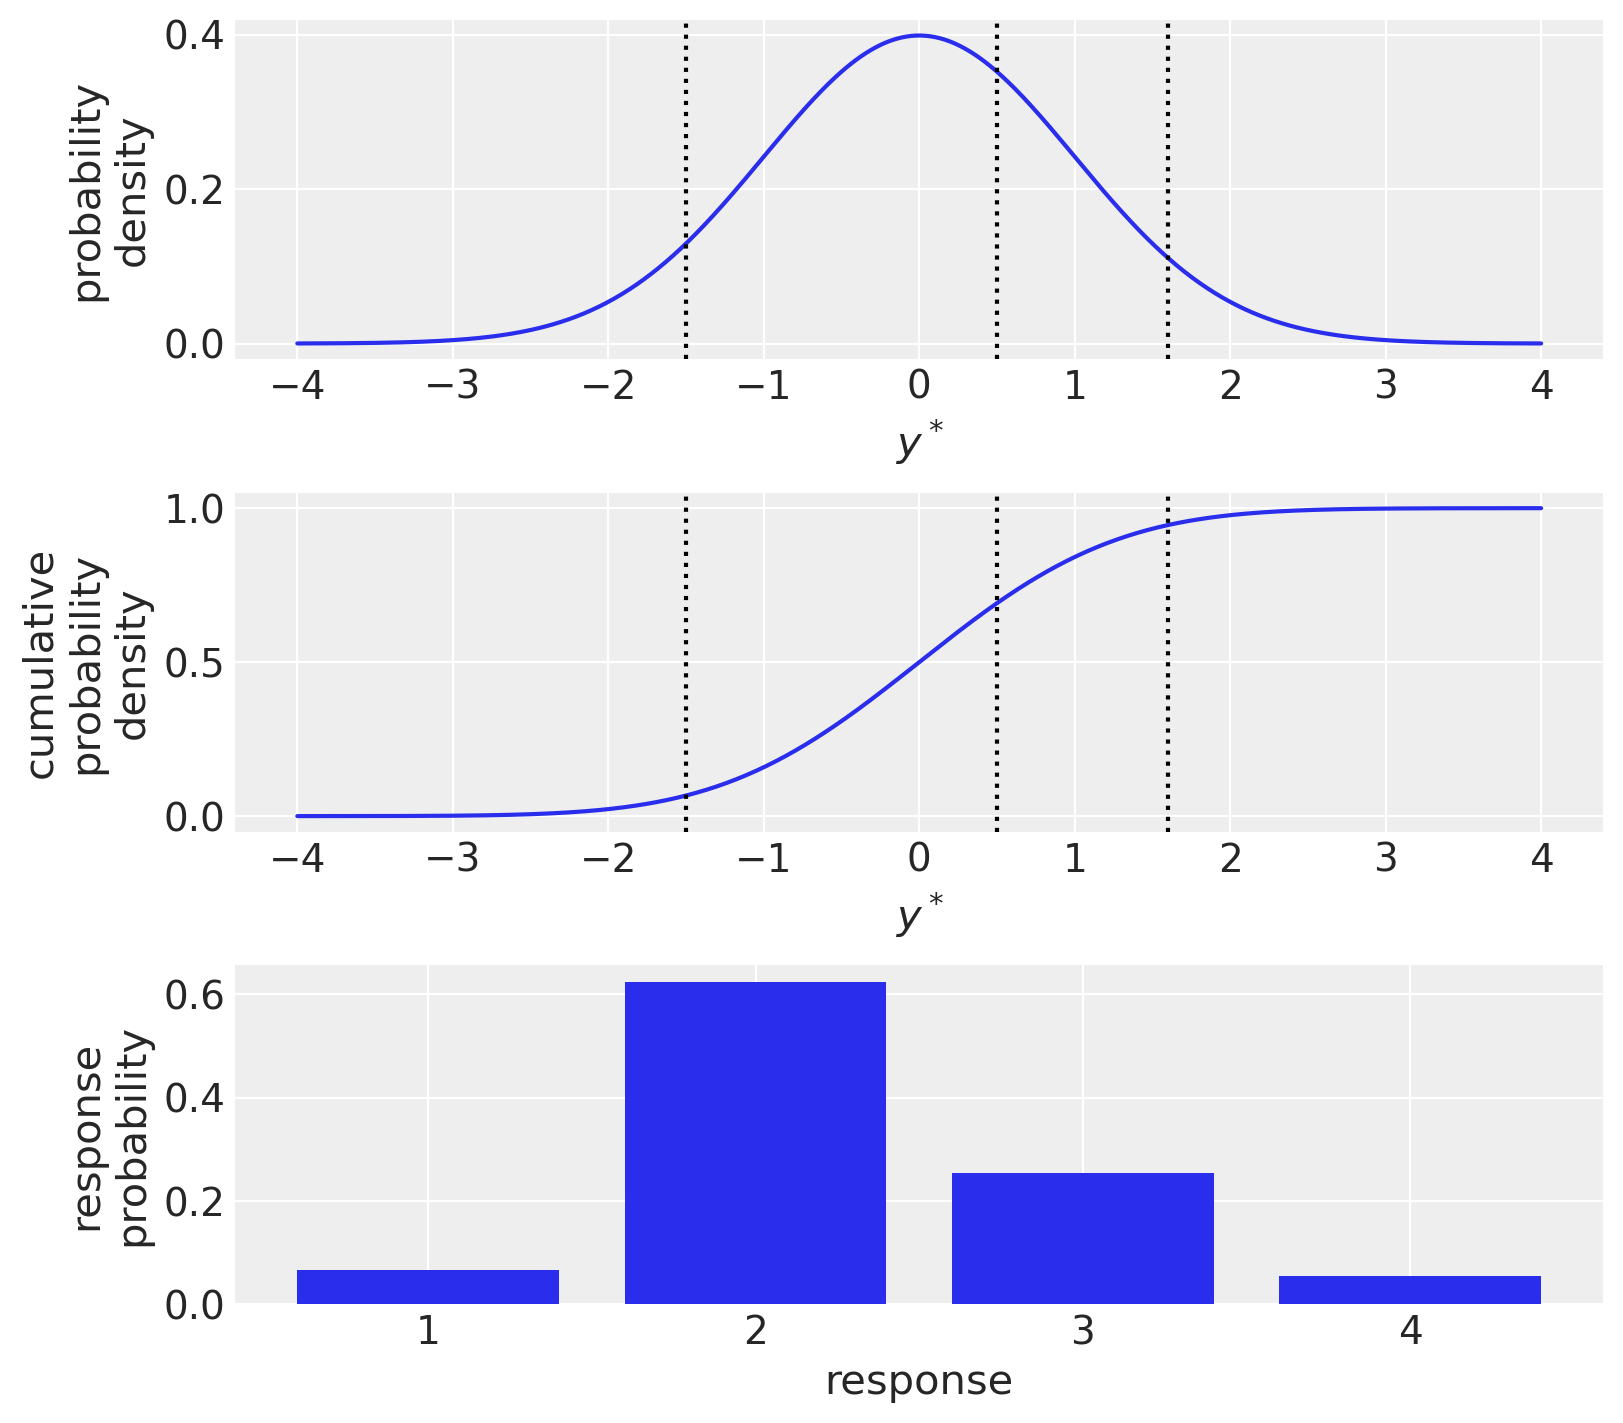

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))
cutpoints=[-1.5, 0.5, 1.6]
# Gaussian distribution over y*
ystar = np.linspace(-4, 4, 500)
ax[0].plot(ystar, norm.pdf(ystar, loc=0, scale=1))
ax[0].set(xlabel=r"$y^*$", ylabel="probability\ndensity")
[ax[0].axvline(x=c, c='k', ls=':') for c in cutpoints]
# Cumulative Gaussian over y*
ax[1].plot(ystar, norm.cdf(ystar, loc=0, scale=1))
ax[1].set(xlabel=r"$y^*$", ylabel="cumulative\nprobability\ndensity")
[ax[1].axvline(x=c, c='k', ls=':') for c in cutpoints]
# Response probability
θ = np.concatenate(([-np.inf], cutpoints, [np.inf]))
p = np.diff([norm.cdf(cut, loc=0, scale=1) for cut in θ])
ax[2].bar([1, 2, 3, 4], p)
ax[2].set(xlabel="response", ylabel="response\nprobability", xticks=[1, 2, 3, 4]);

The cumulative ordinal model proposes that responses $Y$ are generated from some underlying unobserved (latent) variable $y^*$. For the moment we will consider $y^*$ distributed according to a unit normal distribution.

Moving from left to right, we assume that if the value of $y^*$ is low, then the lowest response will be generated. But as the value of $y^*$ increases so that it passes a threshold $\theta_1$, then the second response will be generated. And as the value of $y^*$ increases further, past the threshold $\theta_2$ then the second response will be generated - and so on. 

If we have $K$ possible responses, we will have a set of $K-1$ thresholds, $\theta_1, \ldots, \theta_{K-1}$ also known as cutpoints. Referring to the figure above, we can calculate the proportion of responses $Y= \{ 1, \ldots, 4 \}$ that would result from a given a set of thresholds as:

$$P(Y=1) = \Phi(\theta_1) - \Phi(-\infty) = \Phi(\theta_1) - 0$$

response 2 as:

$$P(Y=2) = \Phi(\theta_2) - \Phi(\theta_1)$$

response 3 as:

$$P(Y=3) = \Phi(\theta_3) - \Phi(\theta_2)$$

and response 4 as:

$$P(Y=4) = \Phi(\infty) - \Phi(\theta_3) = 1 - \Phi(\theta_3)$$

where $\Phi$ is the standard cumulative normal.

Note: the implicit assumption here is that there is one set of response thresholds $\theta$ that apply to each participant generating a response.

Based on what we have covered so far, we can see that the [`OrderedLogistic`](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.OrderedLogistic) likelihood function offered by PyMC3 will be useful. More information about the ordered logit model can be found on [Wikepedia](https://en.wikipedia.org/wiki/Ordered_logit). The inverse logit (i.e. $\text{logit}^{-1}$) function is $p = \frac{1}{1+\exp(-y^*)}$ and is a close approximation to the cumulative normal distribution.

In [41]:
def inverse_logit(x):
    return 1 / (1 + np.exp(-x))

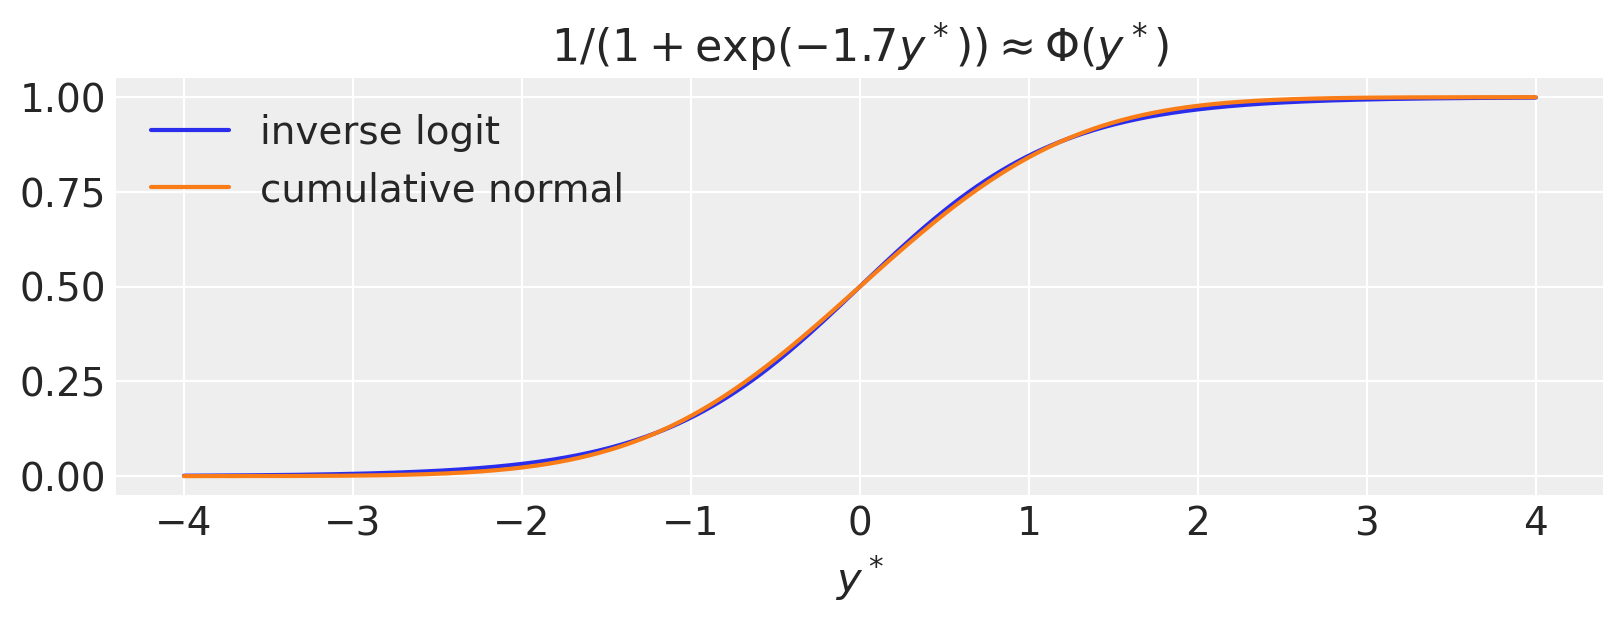

In [42]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ystar, inverse_logit(1.7*ystar), label='inverse logit')
ax.plot(ystar, norm.cdf(ystar, loc=0, scale=1), label='cumulative normal')
ax.set(title=r"$1/(1+\exp(-1.7y^*)) \approx \Phi(y^*)$", xlabel=r"$y^*$")
ax.legend();

# Example 1: Fitting a single group
We will go through the first example in some detail. By focussing on the simplest case where we have one set of observed proportions we can test the model and make sure we understand how it works.

Sample size = 100, Levels = 7


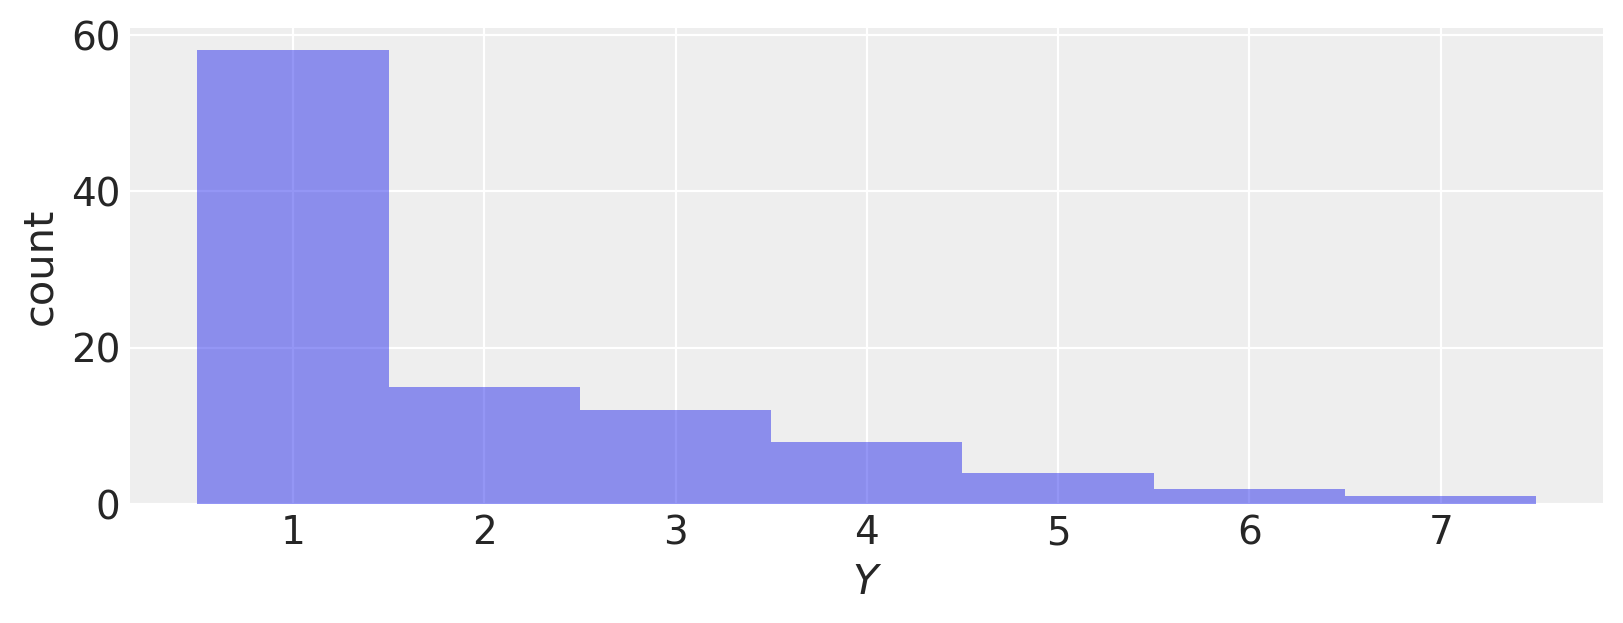

In [43]:
# import data
df = pd.read_csv("DBDA2Eprograms/OrdinalProbitData-1grp-1.csv")
y = df.Y.values
K = len(np.unique(y))
N = len(y)
print(f'Sample size = {N}, Levels = {K}')

# visualise data
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(y, np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]), alpha=0.5)
ax.set(xlabel="$Y$", ylabel="count");

### Create PyMC3 model. 

A few things to note:
- The `y` values must start from 0, hence the `observed=y-1` part in the PyMC3 model below.
- We set $\eta=0$.

In [44]:
with pm.Model() as model:
    cutpoints = pm.Normal("cutpoints", mu=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
                          sigma=0.5, shape=6,
                          transform=pm.distributions.transforms.ordered)
    pm.OrderedLogistic("y", cutpoints=cutpoints, eta=0, observed=y-1)

### Do the MCMC sampling.

In [45]:
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cutpoints]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


Visual check of MCMC chains.

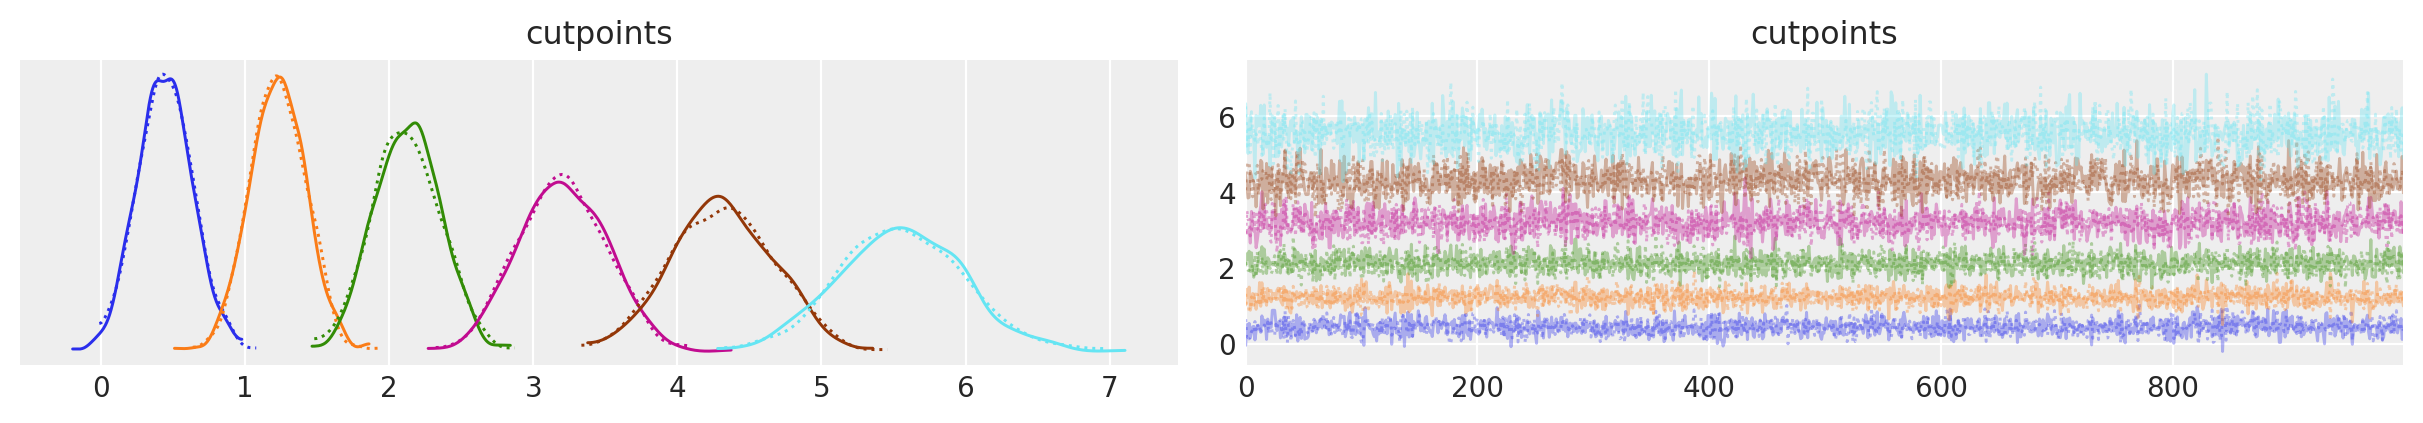

In [46]:
az.plot_trace(trace);

### Checking our understanding of the model
Let's check that this makes sense. If we use the posterior median cutpoints and use those to calculate the response proportions (using the inverse logit function), then these should offer a close match to the actual proportions. The figure below visually demonstrates this procedure. Note that this works because we set $\eta=0$ in the PyMC3 model.

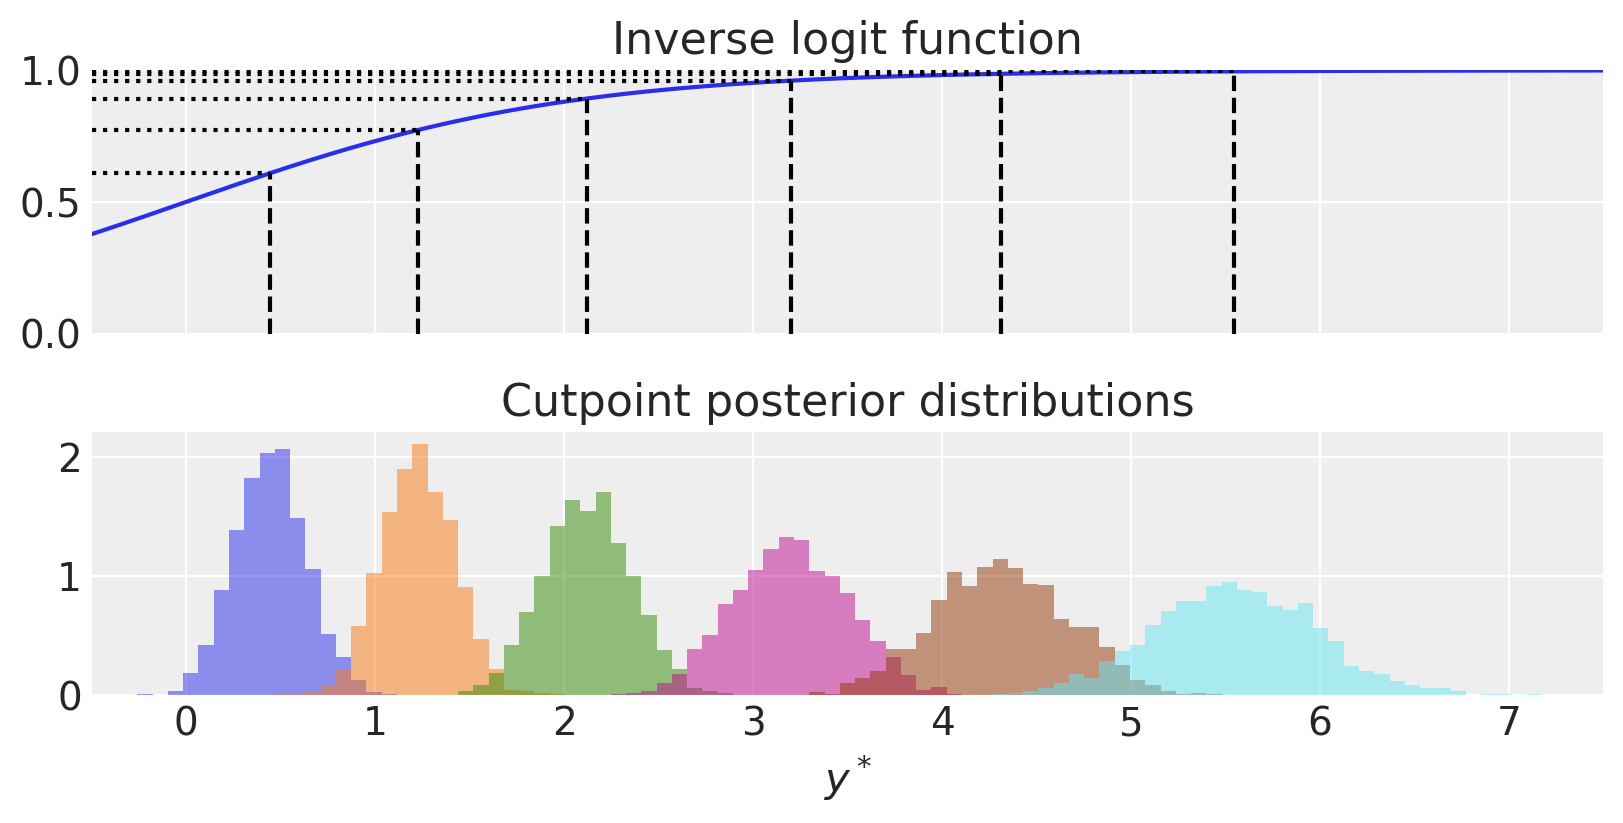

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# inverse logit function plot
ystar = np.linspace(-0.5, 7.5, 500)
ax[0].plot(ystar, inverse_logit(ystar), label='inverse logit')
ax[0].set(ylim=(0, 1), title="Inverse logit function")
for i in [0, 1, 2, 3, 4, 5]:
    # horizontal
    x = np.median(trace.posterior.cutpoints[:,:,i].values.flatten())
    ax[0].plot([x, x], [0, inverse_logit(x)], c='k', ls="--")
    # vertical
    ax[0].plot([-0.5, x], [inverse_logit(x), inverse_logit(x)], c='k', ls="--")
    
# plot cutpoint posteriors   
for i in [0, 1, 2, 3, 4, 5]:
    ax[1].hist(trace.posterior.cutpoints[:,:,i].values.flatten(), 
               bins=np.linspace(-0.5, 7.5, 100), density=True, alpha=0.5)
ax[1].set(title="Cutpoint posterior distributions", xlabel="$y^*$", xlim=(-0.5, 7.5)); 

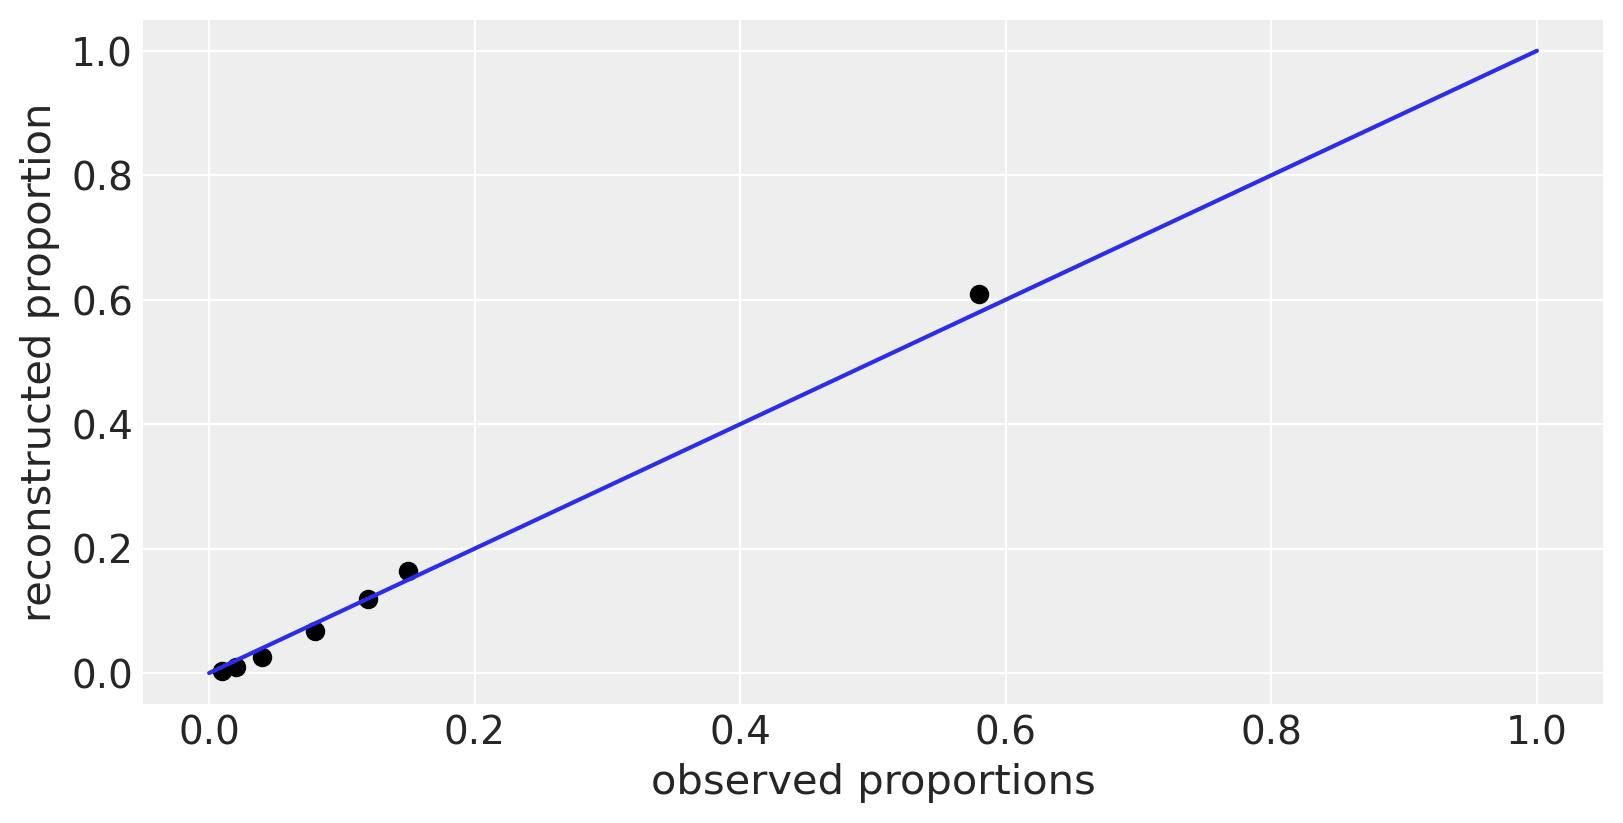

In [48]:
# median cut points
cp = [np.median(trace.posterior.cutpoints[:,:,i].values.flatten()) 
      for i in [0, 1, 2, 3, 4, 5]]

# reconstructed proportions, from cutpoints and inverse_logit
props = np.array([inverse_logit(cp[0]), 
                  inverse_logit(cp[1]) - inverse_logit(cp[0]),
                  inverse_logit(cp[2]) - inverse_logit(cp[1]),
                  inverse_logit(cp[3]) - inverse_logit(cp[2]),
                  inverse_logit(cp[4]) - inverse_logit(cp[3]),
                  inverse_logit(cp[5]) - inverse_logit(cp[4]),
                  1 - inverse_logit(cp[5])])

# empirically observed proportions
props_observed = np.bincount(y-1) / N

# visualise similarity between observed and reconstructed proportions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot([0, 1], [0, 1])
ax.scatter(props_observed, props, c='k')
ax.set(xlabel="observed proportions", ylabel="reconstructed proportion");

So our checks are reasonable. We reconstructed the response proportions by using the posterior median cutoff points and the inverse logit function. These reconstructed proportions are very close to the observed proportions.

### Posterior prediction
We can go further and construct a posterior predictive distribution. This is a useful visual check that the model fits the data. We have already achieved this to some extent with the scatter plot comparing observed and reconstructed proportions above. But using posterior prediction will also allow us to see the credible regions for the response proportions.

In [49]:
pp_samples = 2000
post_pred = pm.sample_posterior_predictive(trace, samples=pp_samples, model=model)
ypp = post_pred["y"]

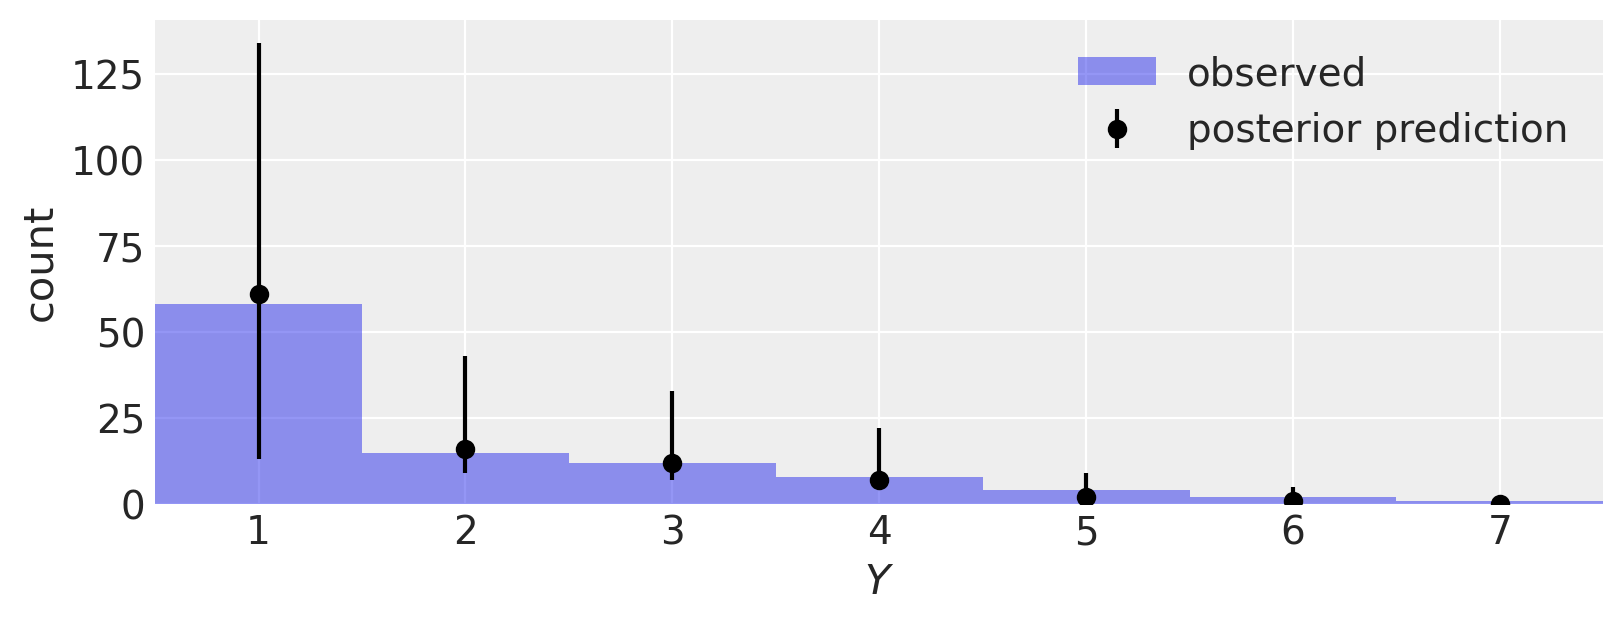

In [50]:
# Calculate 2.5, 50, 97.5th percentiles -------------------
# Count frequency of responses
counts = np.zeros((pp_samples,K))
for i in range(pp_samples):
    counts[i,:] = np.bincount(ypp[i,:], minlength=K)
# Calculate percentiles
ypp_stats = np.percentile(counts, [2.5, 50, 97.5], axis=0)

# visualise data ------------------------------------------
fig, ax = plt.subplots(figsize=(8, 3))
# plot data
ax.hist(y, np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]), 
        alpha=0.5, label="observed")
ax.set(xlabel="$Y$", ylabel="count");
# plot posterior predictive as errorbars
ax.errorbar(x=[1, 2, 3, 4, 5, 6, 7], 
            y=ypp_stats[1,:], 
            yerr=ypp_stats[(0,2),:], fmt='o', c='k', 
            label='posterior prediction')
ax.set(xlim=(0.5, 7.5))
ax.legend();

If we want, we can visualise a couple of draws from the posterior predictive distribution.

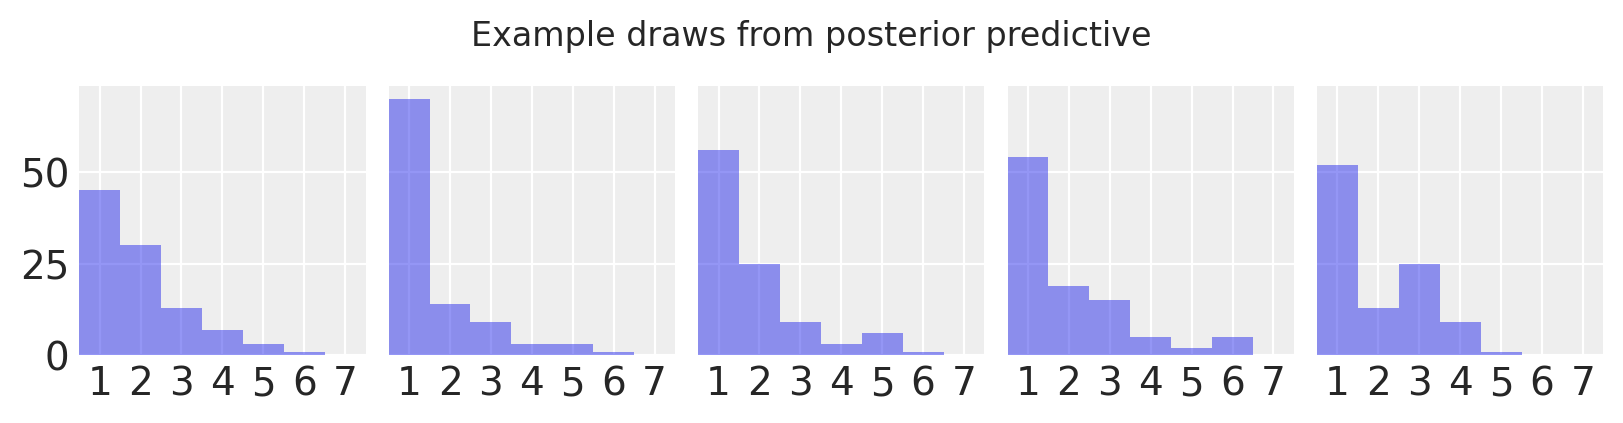

In [51]:
fig, ax = plt.subplots(1, 5, figsize=(8, 2), sharey=True)
fig.suptitle("Example draws from posterior predictive")
bin_edges = np.arange(K)+0.5
for i, axis in enumerate(ax):
    axis.hist(ypp[i,:]+1, bin_edges, alpha=0.5)
    axis.set(xticks=[1, 2, 3, 4, 5, 6, 7], xlim=(0.5, 7.5))

Now we go on to visualise the posterior median and 95% credible intervals.

# Example 2: Making this a regression model
The model we looked at above modelled the latent distribution of $y^*$ as a zero mean, unit variance normal distribution. As such, the only parameters being estimated were the cut points.

In this model we will add in an unknown mean.

In [52]:
with pm.Model() as model2:
    eta = pm.Normal("eta", mu=0, sigma=1)
    cutpoints = pm.Normal("cutpoints", mu=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
                          sigma=0.5, shape=6,
                          transform=pm.distributions.transforms.ordered)
    pm.OrderedLogistic("y", cutpoints=cutpoints, eta=eta, observed=y-1)

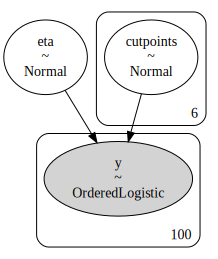

In [53]:
pm.model_to_graphviz(model2)

In [54]:
with model2:
    trace2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cutpoints, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


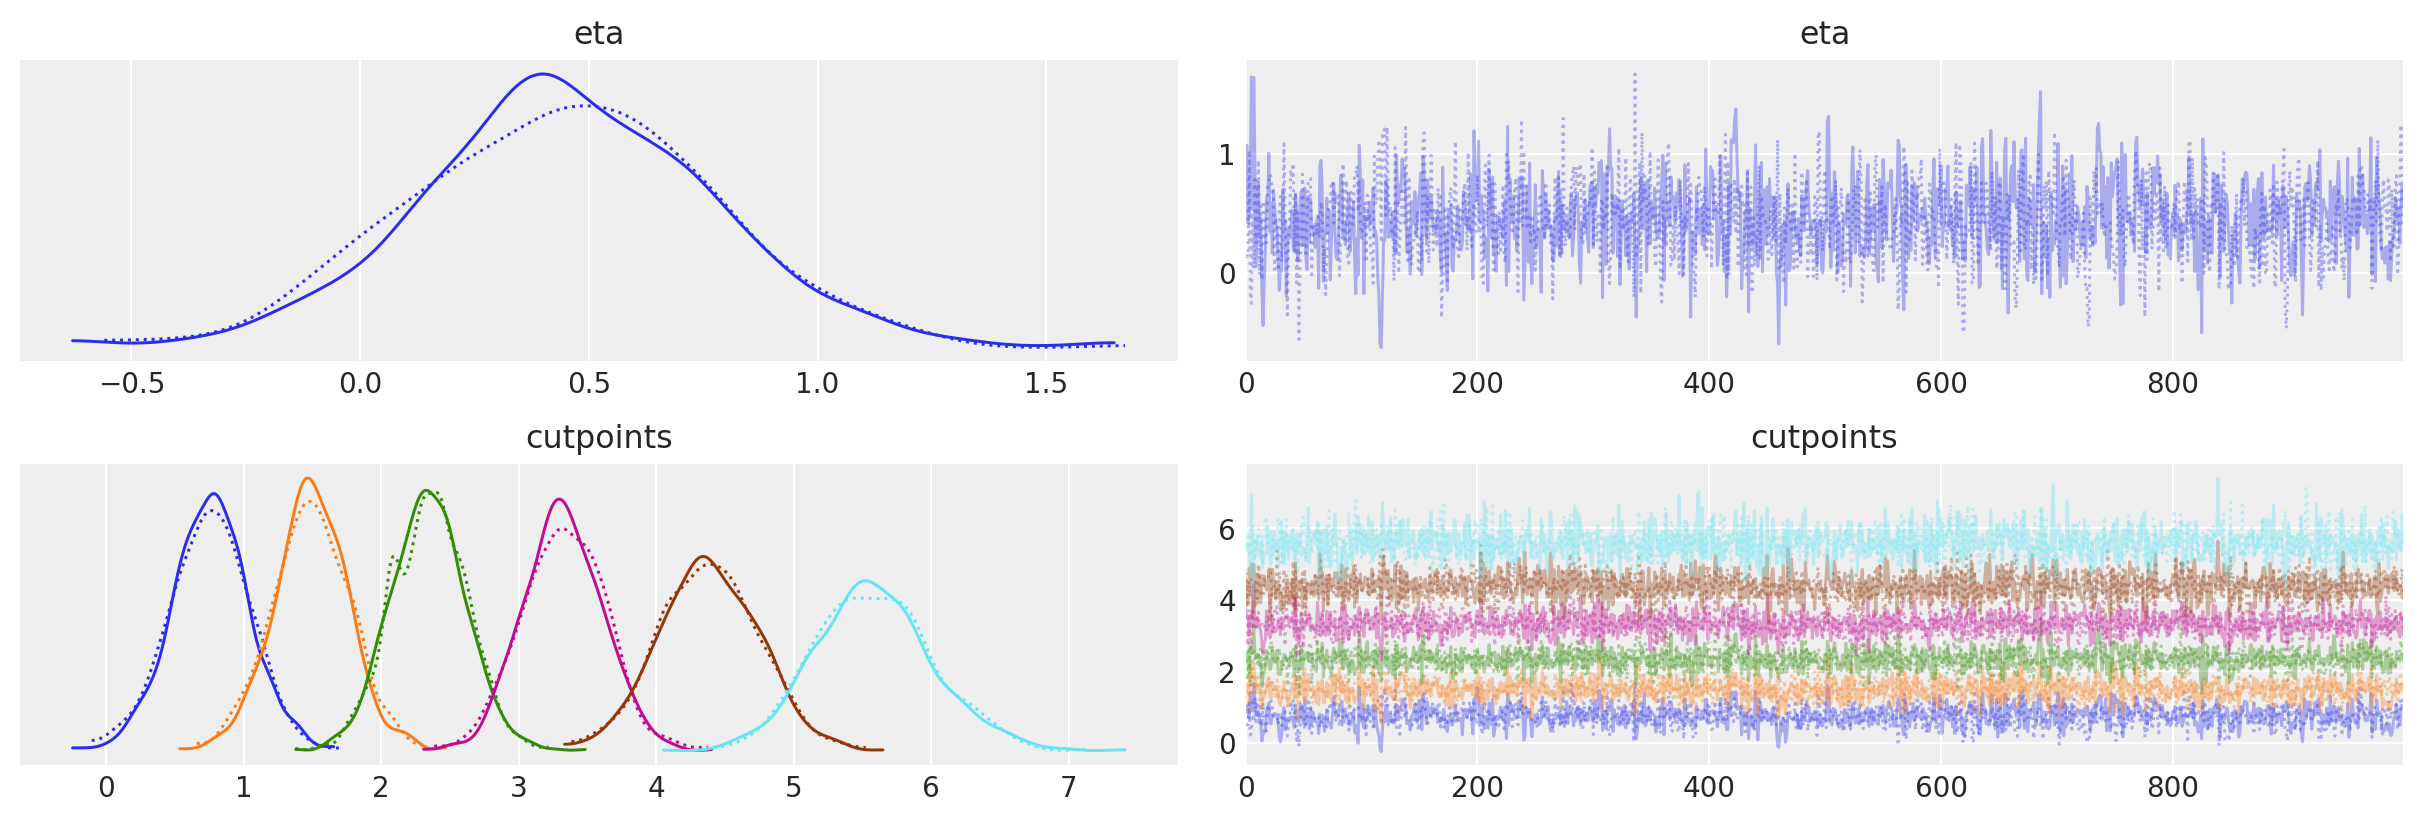

In [55]:
az.plot_trace(trace2);

In [56]:
pp_samples = 2000
post_pred = pm.sample_posterior_predictive(trace2, samples=pp_samples, model=model2)
ypp = post_pred["y"]

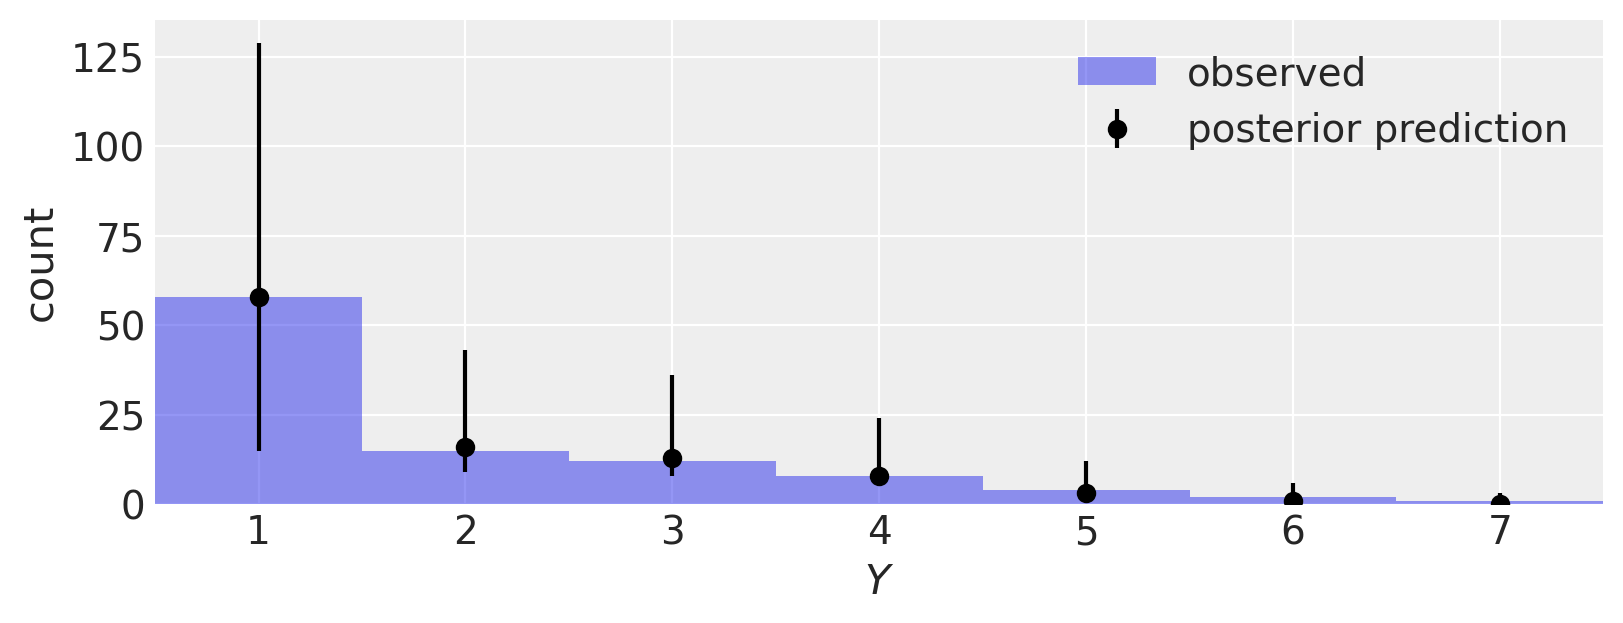

In [57]:
# Calculate 2.5, 50, 97.5th percentiles -------------------
# Count frequency of responses
counts = np.zeros((pp_samples,K))
for i in range(pp_samples):
    counts[i,:] = np.bincount(ypp[i,:], minlength=K)
# Calculate percentiles
ypp_stats = np.percentile(counts, [2.5, 50, 97.5], axis=0)

# visualise data ------------------------------------------
fig, ax = plt.subplots(figsize=(8, 3))
# plot data
ax.hist(y, np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]), 
        alpha=0.5, label="observed")
ax.set(xlabel="$Y$", ylabel="count");
# plot posterior predictive as errorbars
ax.errorbar(x=[1, 2, 3, 4, 5, 6, 7], 
            y=ypp_stats[1,:], 
            yerr=ypp_stats[(0,2),:], fmt='o', c='k', 
            label='posterior prediction')
ax.set(xlim=(0.5, 7.5))
ax.legend();

# Example 3: Ordinal regression with a continuous predictor

# Example 4: Ordinal regression with 2 groups

Now we slightly change gears to examine the case where we have 2 groups, that is where the predictor variable is a single binary variable corresponding to group 1 or group 2.

In [58]:
# import data
df = pd.read_csv("DBDA2Eprograms/OrdinalProbitData1.csv")

y, X = patsy.dmatrices("Y ~ X", df)
# convert to arrays
y, X = np.asarray(y), np.asarray(X)

n_β = X.shape[1]
n_β

2

In [66]:
df.shape

(88, 2)

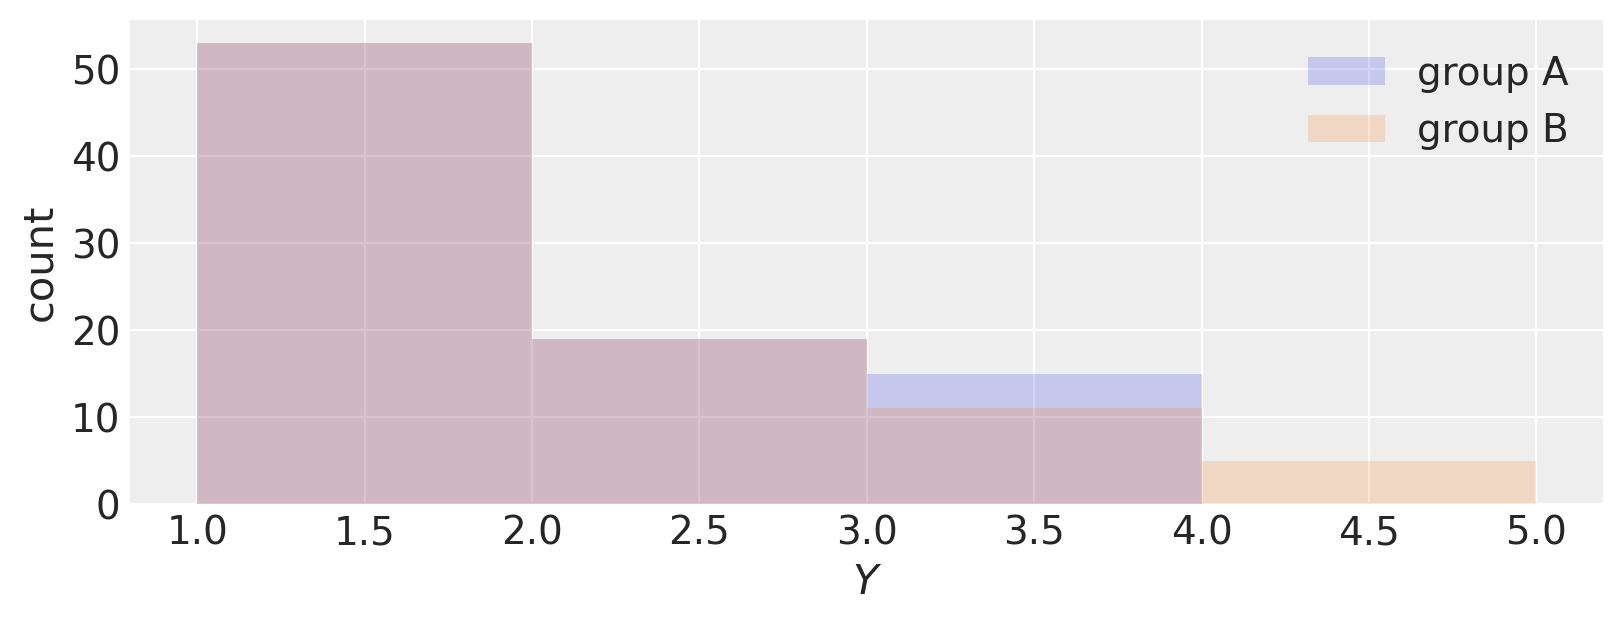

In [59]:
# recode group from A/B to 0/1
df['X'] = df['X'].map({'A': 0, 'B': 1})

# extract values
x = df.X.values
y = df.Y.values

# visualise the responses by group
fig, ax = plt.subplots(figsize=(8, 3))

ax.hist(y, df.loc[df['X'] == 0].Y, np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
        alpha=0.2, label="group A")
ax.hist(y, df.loc[df['X'] == 1].Y, np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
        alpha=0.2, label="group B")
ax.set(xlabel="$Y$", ylabel="count")
ax.legend();

In [60]:
with pm.Model() as model3:
    # priors
    β = pm.Normal("β", mu=0, sd=1, shape=(n_β,1))  # Note β must be a column vector
    cutpoints = pm.Normal("cutpoints", mu=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
                          sigma=0.5, shape=6,
                          transform=pm.distributions.transforms.ordered)
    # likelihood
    ystar = pm.math.dot(X, β)
    pm.OrderedLogistic("y", cutpoints=cutpoints, eta=ystar, observed=y-1)

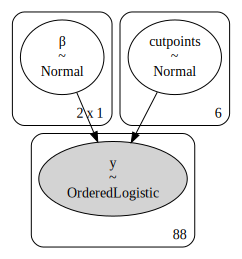

In [61]:
pm.model_to_graphviz(model3)

In [62]:
with model3:
    trace3 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cutpoints, β]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 83 seconds.


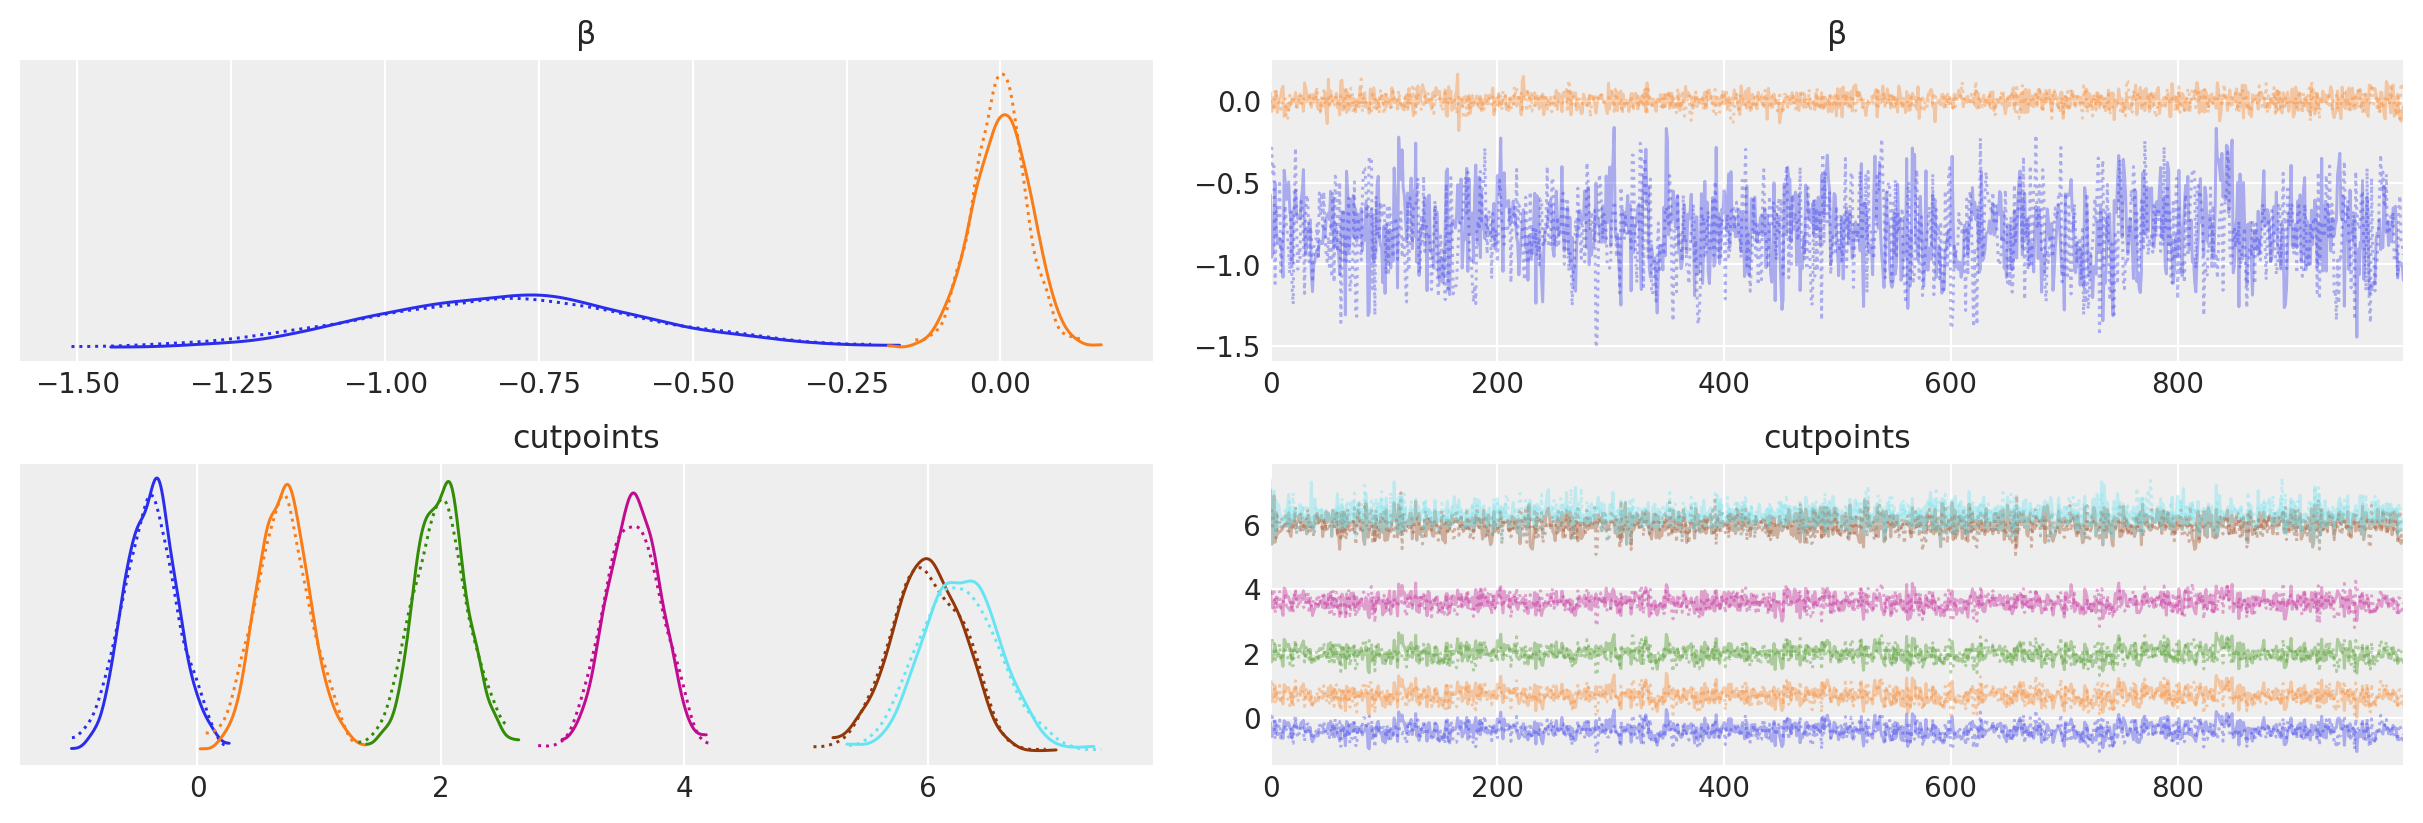

In [63]:
az.plot_trace(trace3);

In [69]:
pp_samples = 500
post_pred = pm.sample_posterior_predictive(trace3, model=model3, keep_size=True)  # samples=pp_samples, 
ypp = post_pred["y"]

In [70]:
# plot posterior predictive here
ypp.shape

(2, 1000, 88, 88)

# NOTE SURE THIS SHAPE IS CORRECT

In [67]:
?pm.sample_posterior_predictive

Signature:
pm.sample_posterior_predictive(
    trace,
    samples: Union[int, NoneType] = None,
    model: Union[pymc3.model.Model, NoneType] = None,
    var_names: Union[List[str], NoneType] = None,
    size: Union[int, NoneType] = None,
    keep_size: Union[bool, NoneType] = False,
    random_seed=None,
    progressbar: bool = True,
) -> Dict[str, numpy.ndarray]
Docstring:
Generate posterior predictive samples from a model given a trace.

Parameters
----------
trace : backend, list, xarray.Dataset, arviz.InferenceData, or MultiTrace
    Trace generated from MCMC sampling, or a list of dicts (eg. points or from find_MAP()),
    or xarray.Dataset (eg. InferenceData.posterior or InferenceData.prior)
samples : int
    Number of posterior predictive samples to generate. Defaults to one posterior predictive
    sample per posterior sample, that is, the number of draws times the number of chains. It
    is not recommended to modify this value; when modified, some chains may not be represent

# References
- Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 42(4), 251524591882319–25. Retrieved from https://doi.org/10.1177/2515245918823199
- Kruschke, J. K. (2015). Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan (2nd ed.). Academic Press.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray